In [1]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt

from utils.gmm_performance_correlation import GMMPerformanceCorrelation
from datasets.dpav4 import DPAv4
from trials.utils import *

In [2]:
stats_path = os.path.join('..', 'outputs', 'dpav4__backup', 'first_order_stats', 'stats.npy')
stats = np.load(stats_path)
snr = stats[0, :]
profiling_dataset = DPAv4(root=r'/mnt/hdd/jgammell/leakage_localization/downloads/dpav4', train=True)
attack_dataset = DPAv4(root=r'/mnt/hdd/jgammell/leakage_localization/downloads/dpav4', train=False)

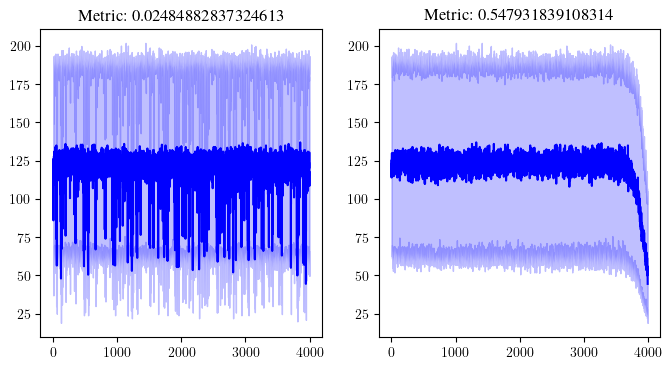

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for idx, feature_ranking in enumerate([np.random.randn(profiling_dataset.timesteps_per_trace).argsort(), snr.argsort()]):
    metric = GMMPerformanceCorrelation(feature_ranking, device='cuda')
    metric.profile(profiling_dataset)
    out, ranks = metric(attack_dataset, return_ranks=True)
    median = np.median(ranks, axis=1)
    q25 = np.percentile(ranks, 25, axis=1)
    q75 = np.percentile(ranks, 75, axis=1)
    axes[idx].fill_between(np.arange(len(median)), q25, q75, color='blue', alpha=0.25)
    axes[idx].plot(median, color='blue')
    axes[idx].set_title(f'Metric: {out}')

In [21]:
base_path = r'/home/jgammell/Desktop/mi_leakage_localization/outputs/dpav4__backup/hparam_tune'
metrics = {
    key: {'max': [], 'final': []}
    for key in ['gmmperfcorr', 'val_theta_rank']
}
for trial_dir in os.listdir(base_path):
    training_curves = get_training_curves(os.path.join(base_path, trial_dir))
    for key in metrics.keys():
        metrics[key]['max'].append(np.max(training_curves[key][-1]))
        metrics[key]['final'].append(training_curves[key][-1][-1])
for key, val in metrics.items():
    metrics[key] = {'max': np.array(val['max']), 'final': np.array(val['final'])}
max_indices = np.argsort(metrics['gmmperfcorr']['max'])
final_indices = np.argsort(metrics['gmmperfcorr']['final'])
for key, val in metrics.items():
    metrics[key] = {'max': val['max'][max_indices], 'final': val['final'][final_indices]}

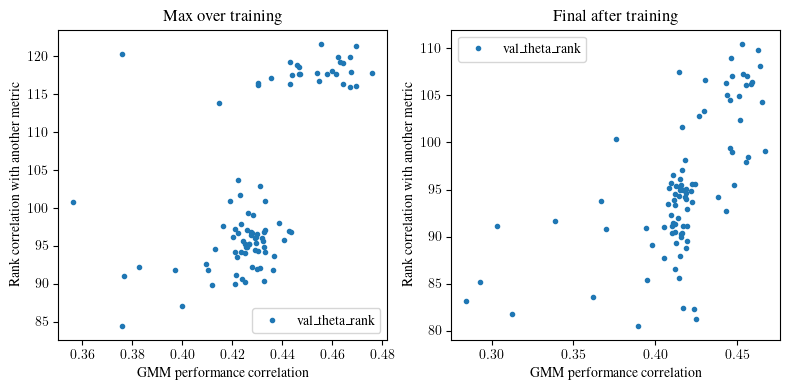

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for key, val in metrics.items():
    if key == 'gmmperfcorr':
        continue
    axes[0].plot(metrics['gmmperfcorr']['max'], val['max'], marker='.', linestyle='none', label=key.replace('_', '\_'))
    axes[1].plot(metrics['gmmperfcorr']['final'], val['final'], marker='.', linestyle='none', label=key.replace('_', '\_'))
axes[0].set_xlabel('GMM performance correlation')
axes[1].set_xlabel('GMM performance correlation')
axes[0].set_ylabel('Rank correlation with another metric')
axes[1].set_ylabel('Rank correlation with another metric')
axes[0].set_title('Max over training')
axes[1].set_title('Final after training')
axes[0].legend()
axes[1].legend()
fig.tight_layout()

In [11]:
gmmperfcorr = {'max': [], 'final': []}
hparams = {key: [] for key in ['etat_lr', 'etat_beta_1', 'etat_beta_2', 'etat_eps', 'theta_weight_decay', 'lr_scheduler', 'noise_scale']}
for trial_dir in os.listdir(base_path):
    training_curves = get_training_curves(os.path.join(base_path, trial_dir))
    key_vals = trial_dir.split('__')
    for key_val in key_vals:
        key, val = key_val.split('=')
        val = float(val) if not key == 'lr_scheduler' else 0. if val == 'None' else 1.
        hparams[key].append(val)
    gmmperfcorr['max'].append(np.max(training_curves['gmmperfcorr'][-1]))
    gmmperfcorr['final'].append(training_curves['gmmperfcorr'][-1][-1])
gmmperfcorr = {key: np.array(val) for key, val in gmmperfcorr.items()}
hparams = {key: np.array(val) for key, val in hparams.items()}

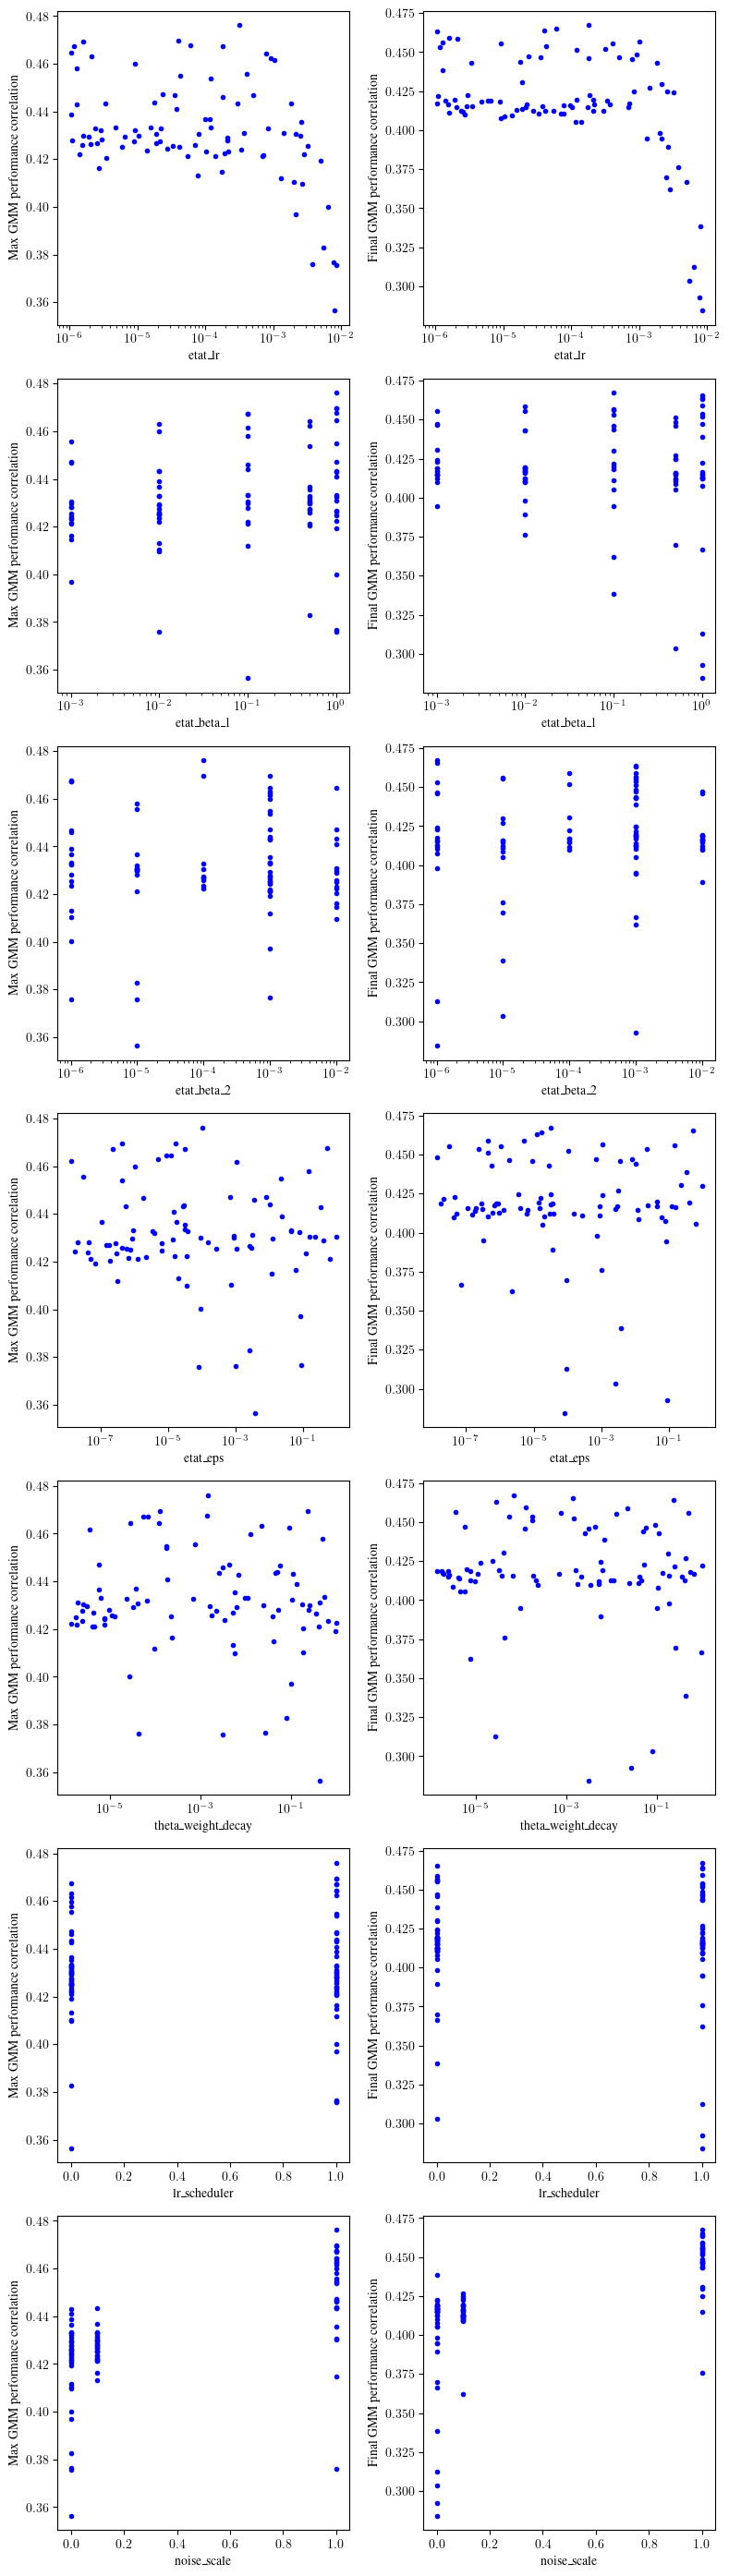

In [13]:
fig, axes = plt.subplots(len(hparams), 2, figsize=(4*2, 4*len(hparams)))
for idx, (hparam_name, hparam_val) in enumerate(hparams.items()):
    axes[idx, 0].plot(1-hparam_val if 'beta' in hparam_name else hparam_val, gmmperfcorr['max'], marker='.', linestyle='none', color='blue')
    axes[idx, 1].plot(1-hparam_val if 'beta' in hparam_name else hparam_val, gmmperfcorr['final'], marker='.', linestyle='none', color='blue')
    axes[idx, 0].set_xlabel(hparam_name.replace('_', '\_'))
    axes[idx, 1].set_xlabel(hparam_name.replace('_', '\_'))
    axes[idx, 0].set_ylabel('Max GMM performance correlation')
    axes[idx, 1].set_ylabel('Final GMM performance correlation')
    if hparam_name in ['etat_lr', 'etat_beta_1', 'etat_beta_2', 'etat_eps', 'theta_weight_decay']:
        axes[idx, 0].set_xscale('log')
        axes[idx, 1].set_xscale('log')
fig.tight_layout()